# Neural Networks

In [1]:
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.utils.data as data_utils
import torchvision
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# Gets training data, randomises and seperates into X,Y values.
otto = pd.read_csv("data/train.csv").sample(frac=1)
ottoX = otto.iloc[:,1:-1]     # remove ID and Label 
ottoY = otto.iloc[:,-1]


# Split data into training and validation set
trainX, valX, trainY, valY = train_test_split(ottoX, ottoY, test_size = 0.2)

otto.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
31468,31469,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,Class_5
36083,36084,0,0,15,10,0,0,0,0,0,...,1,0,0,0,2,0,0,1,0,Class_6
38510,38511,0,0,15,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_6
49299,49300,0,0,0,1,0,0,0,2,2,...,0,1,0,0,1,0,0,5,0,Class_8
39546,39547,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,Class_6


In [2]:
# Convert training sets into tensor form with Pytorch functions
trainX = torch.from_numpy(trainX.values) 
valX = torch.from_numpy(valX.values)

le = preprocessing.LabelEncoder()
le.fit(trainY)
trainY = le.transform(trainY)
trainY = torch.from_numpy(trainY)

le_val = preprocessing.LabelEncoder()
le_val.fit(valY)
valY = le.transform(valY)
valY = torch.from_numpy(valY)

trainX, trainY = trainX.type(torch.FloatTensor), trainY.type(torch.FloatTensor)
valX, valY = valX.type(torch.FloatTensor), valY.type(torch.FloatTensor)


# Load data into DataLoader
processed_train_set = data_utils.TensorDataset(trainX, trainY)
#processed_val_set = data_utils.TensorDataset(valX, valY)
train_loader = data_utils.DataLoader(processed_train_set, batch_size=256, shuffle=True, drop_last=True)
#val_loader = data_utils.DataLoader(processed_val_set, batch_size=256, shuffle=True, drop_last=True)

Converting features and label into float tensor form to be used with the TensorDataset() function later. 

The data is split into a training and validation set with 80/20 ratio and then fed into the TensorDataset() function to be converted into a dataset that DataLoader() can take in. 

Once we get the new training and validation set from TensorDataset() we used DataLoader() to split the data in each set into mini-batches of size 256 each.

## Multilayered Perceptron Neural Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Net(nn.Module):
    def __init__(self, hid, dropout):
        super().__init__()
        self.fc1 = nn.Linear(93, hid)
        self.bn1 = nn.BatchNorm1d(num_features=hid)
        self.fc2 = nn.Linear(hid, hid)
        self.bn2 = nn.BatchNorm1d(num_features=hid)
        self.fc3 = nn.Linear(hid, hid)
        self.bn3 = nn.BatchNorm1d(num_features=hid)
        self.out = nn.Linear(hid, 9)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        fc1 = self.fc1(x)
        bn1 = self.bn1(fc1)
        self.hid1 = torch.tanh(bn1)
        fc2 = self.dropout(self.hid1)
        fc2 = self.fc2(self.hid1)
        bn2 = self.bn2(fc2)
        self.hid2 = torch.tanh(bn2)
        fc2 = self.dropout(self.hid2)
        fc3 = self.fc3(self.hid2)
        bn3 = self.bn3(fc3)
        self.hid3 = torch.tanh(bn3)
        res = self.dropout(self.hid3)
        out = self.out(res)
        return out

The neural network consist of 3 hidden layers with each having 64 hidden nodes, an output layer with 9 nodes to represent the number of unique classes and an input layer with 93 nodes that represent the amount of unique features.

Note that there is no activation applied to "out" above as we will be using the CrossEntropyLoss() function provided by pytorch and by default it will apply log_softmax to calculate the loss.

BatchNormalization and Dropout was used in order to prevent the network from training an overfitting model.

In [5]:
# Custom Loss Function

def log_loss(y_pred, y_label, eps=1e-15):
    y_label = y_label.view(-1,1).long()
    res = torch.gather(y_pred, 1,y_label)
    res = torch.clamp(res, eps, 1-eps)
    res = -torch.log(res)
    res = torch.mean(res)
    return res

In [6]:
def testAccuracy(net, feat, expected, device):
    net.eval() # Set network to evaluation mode
    X = feat
    y = expected
    X = X.to(device)
    output = net(X)
    
    correct, total = 0, 0
    for idx, i in enumerate(output):  
        if torch.argmax(i) == y[idx]:
            correct += 1
        total += 1
        
    accuracy = round(correct/total,3)
    return accuracy

### Model Training

In [7]:
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
        

def trainNet(epoch, lrate, hidden, dropout):

    net = Net(hidden, dropout).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lrate)
    

    EPOCHS = epoch

    for epoch in range(EPOCHS):
        for data in train_loader:
            net.train()
            X, y = data
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            net.zero_grad()
            output = net(X)
            #res = log_loss(output, y)
            loss = nn.CrossEntropyLoss()    
            res = loss(output, y)
            res.backward()
            optimizer.step()

        train_loss = res.item()
    
    return net, train_loss

def printResult(model, epoch, train_loss):
    train_acc = testAccuracy(model, trainX, trainY, device)
    val_acc = testAccuracy(model, valX, valY, device)
    print('Final Result')
    print('--------------------------------------------------')
    print("EPOCH: ", epoch)
    print("Train Loss: {}, Train Accuracy: {}".format(train_loss, train_acc))
    print("Validation Score: ", val_acc)

net, train_loss = trainNet(15, 0.001, 100, 0.5)
printResult(net, 15, train_loss)

Final Result
--------------------------------------------------
EPOCH:  15
Train Loss: 0.4770224094390869, Train Accuracy: 0.824
Validation Score:  0.801


## Running the Trained Model on the Test Dataset

In [8]:
# Gets test data and separates into X,Y values.
test = pd.read_csv("data/test.csv")
ids = test.iloc[:, 0]
test = test.iloc[:,1:]     # remove ID and Label 

# Convert test set into tensor form with Pytorch functions
test = torch.tensor(test.values) 

# Convert values to type float
test = test.type(torch.FloatTensor)


net.eval()
with torch.no_grad():
    X = test
    X = X.to(device)
    output = net(X)

output = F.softmax(output, dim=1)
output = output.to("cpu")
output = output.numpy()

for x in output:
    for i in range(len(x)):
        x[i] = x[i].item()


test_set = pd.DataFrame(output)

for i in range(1, 10):
    col = 'Class_' + str(i)
    test_set = test_set.rename(columns={i-1: col})

test_set.insert(0, 'id', ids)
test_set.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000345,0.404145,0.478060,0.107099,0.000161,0.000279,0.009310,0.000476,0.000124
1,2,0.001450,0.000332,0.000187,0.000057,0.000048,0.954782,0.002139,0.039493,0.001510
2,3,0.000065,0.000004,0.000003,0.000003,0.000005,0.999549,0.000151,0.000160,0.000059
3,4,0.000039,0.832117,0.161973,0.005200,0.000046,0.000029,0.000205,0.000068,0.000323
4,5,0.061416,0.000137,0.000152,0.000013,0.000060,0.002587,0.000766,0.026933,0.907935


In [9]:
test_set.to_csv('nn_result.csv', index=False)

By submitting the results of our test set onto Kaggle, we were able to obtain a public score of 0.51377 and private score of 0.51970 which puts us in position 1550 and 1570 respectively.

## Hyperparameter Tuning for Performance Difference

In [10]:
from scipy.interpolate import UnivariateSpline

def plotNet(x, y, x_min, x_max, y_min, y_max, 
            lin_space, title, x_label, y_label,
            desc, best, acc):
    plt.axis([x_min, x_max, y_min, y_max])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    s = UnivariateSpline(x, y, s=5)
    xs = np.linspace(0, lin_space, len(x))
    ys = s(xs)
    plt.scatter(x, y)
    plt.plot(xs, ys, color='orange')
    plot_min(desc, best, acc)
    plt.show()
    

def plot_min(desc, x, y):
    text= "Best {}={:.2f}, Accuracy={}".format(desc, x, y)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction", bbox=bbox_props, ha="right", va="top")
    plt.annotate(text, xy=(x, y), xytext=(0.94,0.96), **kw)
    plt.savefig("{}.png".format(desc))

### Dropout vs No Dropout

In [11]:
x_dp = []
y_dp = []

for dp in np.arange(0, 1.0, 0.1):
    model, train_loss = trainNet(15, 0.001, 100, dp)
    val_acc = testAccuracy(model, valX, valY, device)
    x_dp.append(dp)
    y_dp.append(round(val_acc, 3))
    

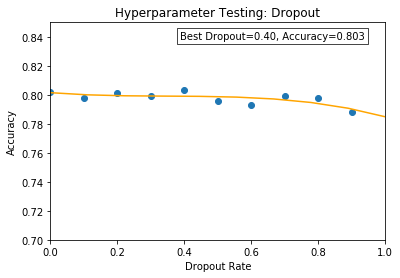

In [12]:
index = y_dp.index(max(y_dp))
plotNet(x_dp, y_dp, 0, 1, 0.7, 0.85, 1.0, 
        "Hyperparameter Testing: Dropout", "Dropout Rate", "Accuracy",
        "Dropout", x_dp[index], y_dp[index])

### Number of Hidden Nodes

In [13]:
x_hid = []
y_hid = []

for hid in np.arange(8, 128, 8):
    model, train_loss = trainNet(15, 0.001, hid, 0.5)
    val_acc = testAccuracy(model, valX, valY, device)
    x_hid.append(hid)
    y_hid.append(round(val_acc, 3))
    

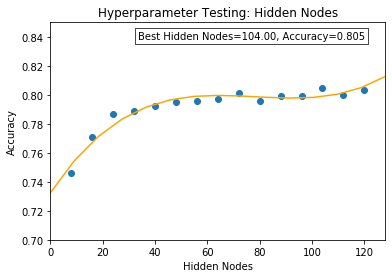

In [14]:
index = y_hid.index(max(y_hid))
plotNet(x_hid, y_hid, 0, 128, 0.7, 0.85, 128,
        "Hyperparameter Testing: Hidden Nodes", "Hidden Nodes", "Accuracy",
        "Hidden Nodes", x_hid[index], y_hid[index])

### Different Learning Rate

In [15]:
x_res = []
y_res = []

# God running this took nearly an hour lol
for lr in np.arange(0.001, 0.11, 0.001):
    model, train_loss = trainNet(10, lr, 100, 0.5)
    val_acc = testAccuracy(model, valX, valY, device)
    x_res.append(lr)
    y_res.append(round(val_acc, 3))
    

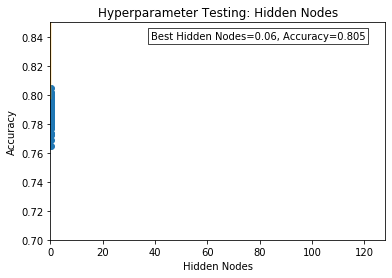

In [16]:
index = y_res.index(max(y_res))
plotNet(x_res, y_res, 0, 128, 0.7, 0.85, 128,
        "Hyperparameter Testing: Hidden Nodes", "Hidden Nodes", "Accuracy",
        "Hidden Nodes", x_res[index], y_res[index])

## Train Model with Hyperparameters Tuning Results

In [17]:
net, train_loss = trainNet(15, 0.002, 96, 0.4)
printResult(net, 15, train_loss)

Final Result
--------------------------------------------------
EPOCH:  15
Train Loss: 0.5737707614898682, Train Accuracy: 0.831
Validation Score:  0.806


## Run Optimized Model on Test Dataset

In [18]:
net.eval()
with torch.no_grad():
    X = test
    X = X.to(device)
    output = net(X)

output = F.softmax(output, dim=1)
output = output.to("cpu")
output = output.numpy()

for x in output:
    for i in range(len(x)):
        x[i] = x[i].item()


test_set = pd.DataFrame(output)

for i in range(1, 10):
    col = 'Class_' + str(i)
    test_set = test_set.rename(columns={i-1: col})

test_set.insert(0, 'id', ids)
test_set.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000207,0.238379,0.174804,0.582687,0.000289,0.000540,0.002944,0.000022,0.000129
1,2,0.000825,0.000431,0.000141,0.000033,0.000043,0.984253,0.004459,0.008788,0.001028
2,3,0.000008,0.000005,0.000005,0.000014,0.000002,0.999718,0.000146,0.000077,0.000025
3,4,0.000132,0.867897,0.112594,0.018837,0.000067,0.000110,0.000194,0.000016,0.000153
4,5,0.097127,0.000358,0.000165,0.000013,0.000055,0.002886,0.001293,0.051007,0.847095


In [19]:
test_set.to_csv('nn_optimized.csv', index=False)